# Part 2.1 : Data Exploration

This notebook explores the data cleaned from the raw Yelp and Housing datasets to find patterns and trends. This data will be used for the Machine Learning Models to predict the type of neighborhoods : Above average Neighborhood tier
or Below average neighborhood tier defined by the States median house price. 

Other data exploration was done on Tableau : [Link](https://public.tableau.com/app/profile/ryan.morin/viz/tableau_restaurants/RestaurantsHousePrices?publish=yes) where you can see our interactive map based on neighborhood tiers and our project analysis. 

In [1]:
# Import dependencies

import json 
import requests 
import pickle

# Importing libraries to work with/explore data:
import pandas as pd
import numpy as np
import datetime, time
from sklearn import preprocessing
from functools import reduce

# Importing libraries to create visualizations:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches

# import itertools
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [2]:
#read in file from AWS

from config import aws_password

import sqlalchemy as db
import psycopg2 as p
connection = p.connect(
    host = "database-1.cx3jpmtuzudq.us-west-1.rds.amazonaws.com",
    port = '5432',
    user = "postgres",
    password = aws_password,
    database = "postgres"
)
sql = '''
SELECT *
FROM public.neighborhood_tier
'''
#Read in the data and create a dataframe
df = pd.read_sql(sql, con=connection)

print(df.shape)
df.head()

(13988, 451)


,postal_code,City,State,CountyName,2021,total_restaurants,total_reviews,avg_rating,total_delivery,total_pickup,...,vermouthbars,shavedsnow,pubfood,bistros,modern_australian,rotisserie_chicken,slovakian,Average County House Price,Neighborhood Indicator,Neighborhood Tiers
0,1267.0,Williamstown,MA,Berkshire County,357029.0,23,1347.0,3.782609,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357029.0,1.000000,1
1,2134.0,Boston,MA,Suffolk County,620830.0,1,2.0,4.500000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,619403.0,1.002304,1
2,11702.0,Babylon,NY,Suffolk County,612637.0,34,6364.0,3.926471,31.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,619403.0,0.989077,1
3,11703.0,North Babylon,NY,Suffolk County,501250.0,5,708.0,4.200000,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,619403.0,0.809247,2
4,11704.0,West Babylon,NY,Suffolk County,501198.0,3,231.0,4.000000,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,619403.0,0.809163,2


#  Tiers  per Restaurant categories

In [3]:
#Extract only category columns
cols = df.columns[237:448]
cat_df = df[cols]
cat_df.head()

,bars,newamerican,wine_bars,italian,tapasmallplates,pizza,breakfast_brunch,mexican,mediterranean,sandwiches,...,kombucha,iberian,piadina,vermouthbars,shavedsnow,pubfood,bistros,modern_australian,rotisserie_chicken,slovakian
0,2.0,0.0,0.0,0.0,0.0,4.0,3.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,6.0,2.0,5.0,0.0,3.0,1.0,2.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Extract only Neighborhood Tiers from dataframe df
tier_df = df["Neighborhood Tiers"]

#Merge dataframes cat_df and tier_df to create a dataframe with only categories and neighborhood tiers. 
df_tiers_cat = pd.merge(tier_df, cat_df, left_index=True, right_index=True)
print(df_tiers_cat.shape)
df_tiers_cat.head()

(13988, 212)


,Neighborhood Tiers,bars,newamerican,wine_bars,italian,tapasmallplates,pizza,breakfast_brunch,mexican,mediterranean,...,kombucha,iberian,piadina,vermouthbars,shavedsnow,pubfood,bistros,modern_australian,rotisserie_chicken,slovakian
0,1,2.0,0.0,0.0,0.0,0.0,4.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2.0,6.0,2.0,5.0,0.0,3.0,1.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Tier1 vs Tier2

In [5]:
# Sum all the categories. You will get True for Tier1 and False for Tier2

df_cat = df_tiers_cat.groupby(df_tiers_cat["Neighborhood Tiers"]==1).sum()
df_cat.head()

,Neighborhood Tiers,bars,newamerican,wine_bars,italian,tapasmallplates,pizza,breakfast_brunch,mexican,mediterranean,...,kombucha,iberian,piadina,vermouthbars,shavedsnow,pubfood,bistros,modern_australian,rotisserie_chicken,slovakian
Neighborhood Tiers,,,,,,,,,,,,,,,,,,,,,
False,13922,5419.0,6155.0,1208.0,5340.0,570.0,12205.0,10397.0,13563.0,1776.0,...,5.0,4.0,0.0,0.0,5.0,2.0,3.0,5.0,0.0,2.0
True,7027,7747.0,9825.0,2533.0,8100.0,998.0,14437.0,13238.0,11438.0,2619.0,...,8.0,4.0,4.0,1.0,3.0,2.0,3.0,8.0,1.0,1.0


In [6]:
#Insert a column Tier2 and Tier1 corresponding to False and True
df_cat.insert(1,"Neighborhood_Tiers", ["Tier2","Tier1"])

In [7]:
df_cat.head()

,Neighborhood Tiers,Neighborhood_Tiers,bars,newamerican,wine_bars,italian,tapasmallplates,pizza,breakfast_brunch,mexican,...,kombucha,iberian,piadina,vermouthbars,shavedsnow,pubfood,bistros,modern_australian,rotisserie_chicken,slovakian
Neighborhood Tiers,,,,,,,,,,,,,,,,,,,,,
False,13922,Tier2,5419.0,6155.0,1208.0,5340.0,570.0,12205.0,10397.0,13563.0,...,5.0,4.0,0.0,0.0,5.0,2.0,3.0,5.0,0.0,2.0
True,7027,Tier1,7747.0,9825.0,2533.0,8100.0,998.0,14437.0,13238.0,11438.0,...,8.0,4.0,4.0,1.0,3.0,2.0,3.0,8.0,1.0,1.0


In [8]:
#drop "Neighborhood Tiers" columns
df_cat = df_cat.drop(columns=["Neighborhood Tiers"], axis=1)

In [9]:
#reset index
df_cat = df_cat.reset_index()
df_cat.head()

,Neighborhood Tiers,Neighborhood_Tiers,bars,newamerican,wine_bars,italian,tapasmallplates,pizza,breakfast_brunch,mexican,...,kombucha,iberian,piadina,vermouthbars,shavedsnow,pubfood,bistros,modern_australian,rotisserie_chicken,slovakian
0,False,Tier2,5419.0,6155.0,1208.0,5340.0,570.0,12205.0,10397.0,13563.0,...,5.0,4.0,0.0,0.0,5.0,2.0,3.0,5.0,0.0,2.0
1,True,Tier1,7747.0,9825.0,2533.0,8100.0,998.0,14437.0,13238.0,11438.0,...,8.0,4.0,4.0,1.0,3.0,2.0,3.0,8.0,1.0,1.0


In [10]:
#drop "Neighborhood Tiers" column again
df_cat = df_cat.drop(columns=["Neighborhood Tiers"], axis=1)
df_cat.head()

,Neighborhood_Tiers,bars,newamerican,wine_bars,italian,tapasmallplates,pizza,breakfast_brunch,mexican,mediterranean,...,kombucha,iberian,piadina,vermouthbars,shavedsnow,pubfood,bistros,modern_australian,rotisserie_chicken,slovakian
0,Tier2,5419.0,6155.0,1208.0,5340.0,570.0,12205.0,10397.0,13563.0,1776.0,...,5.0,4.0,0.0,0.0,5.0,2.0,3.0,5.0,0.0,2.0
1,Tier1,7747.0,9825.0,2533.0,8100.0,998.0,14437.0,13238.0,11438.0,2619.0,...,8.0,4.0,4.0,1.0,3.0,2.0,3.0,8.0,1.0,1.0


In [11]:
#Transpose the Categories column
df_T = df_cat.set_index('Neighborhood_Tiers').T.rename_axis('Categories').reset_index().rename_axis(None, axis=1)
df_T.head()


,Categories,Tier2,Tier1
0,bars,5419.0,7747.0
1,newamerican,6155.0,9825.0
2,wine_bars,1208.0,2533.0
3,italian,5340.0,8100.0
4,tapasmallplates,570.0,998.0


In [12]:
#Total number of Tier2 restaurants
total_tier2 = df.groupby(df["Neighborhood Tiers"]==2).sum()["num_rest_types"]
total_tier2

#Total number of Tier1 restaurants
total_tier1 = df.groupby(df["Neighborhood Tiers"]==1).sum()["num_rest_types"]
total_tier1


Neighborhood Tiers
False    106812
True     120451
Name: num_rest_types, dtype: int64

In [13]:
#Filter the top 30 Tier2 categories
df1 = df_T.nlargest(30, "Tier2")


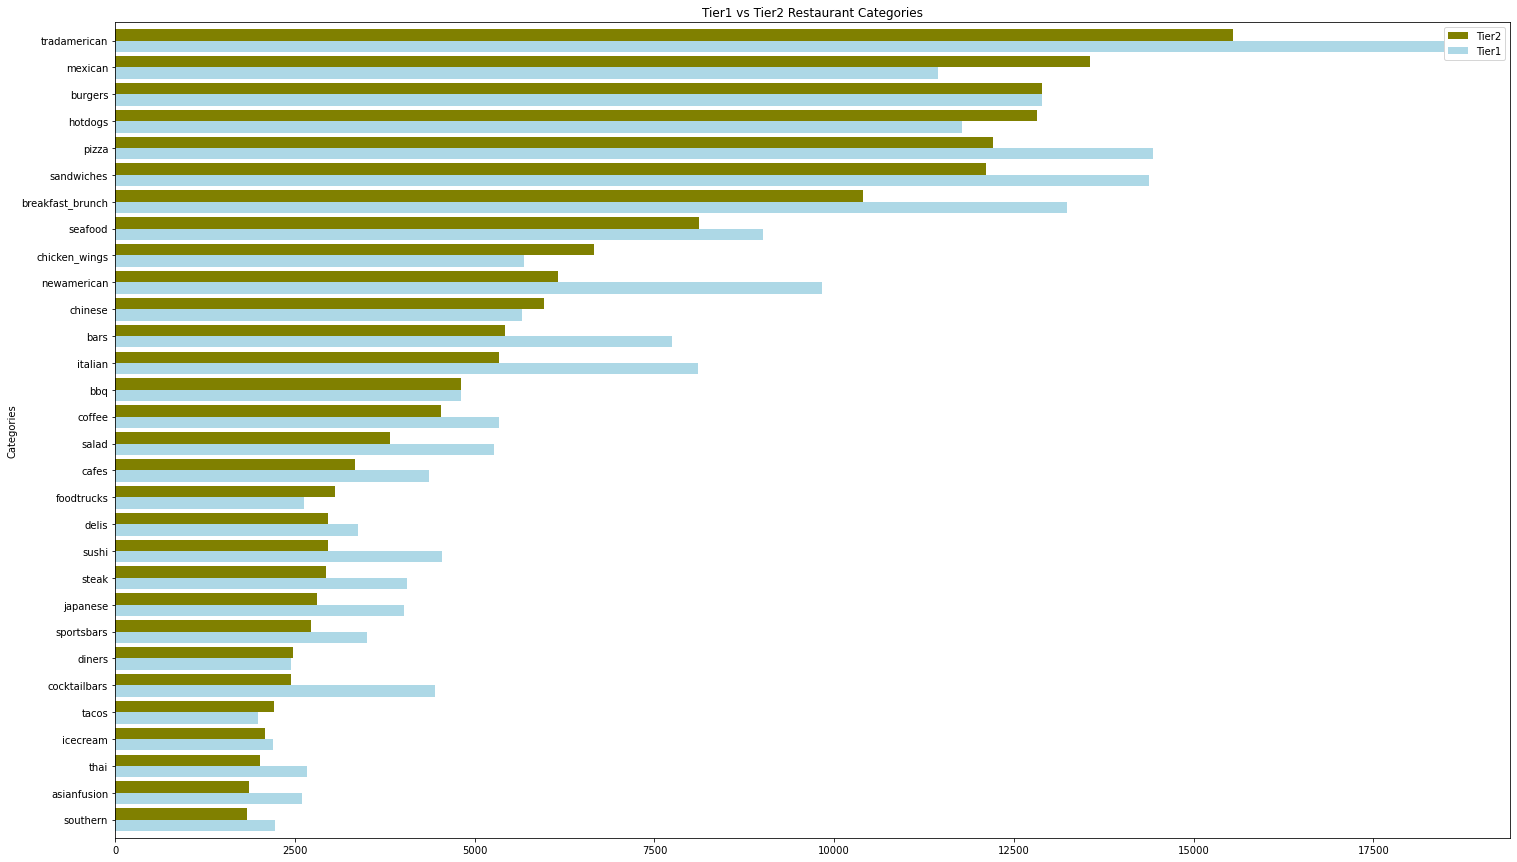

In [31]:
# plotting graph

df1.plot(x="Categories", y=["Tier2", "Tier1"], 
         kind="barh",color = ['olive', 'lightblue'], figsize=(25, 15), width=0.85).invert_yaxis()
plt.title("Tier1 vs Tier2 Restaurant Categories")
plt.yticks()

plt.show()

The top Tier1 Neighborhood Restaurant categories is comapared to Tier2 Neighborhood. We can see that Tier1 Neighborhoods have significantly more Cafes (includes coffeeshops), Sandwiches Bars(cocktail bars, sports bars etc), Brunch, Italian, French, Japanese and Mediterranean restaurant categories. Whereas Tier2 Neighborhoods have more Latin American, Mexican, Chinese Fastfood(burgers, chickenwings, hotdogs etc). Interestingly Pizza which is considered fast food in United States is in larger numbers in Tier1 Neighborhoods. 

# Trend Analysis with Scatterplots

#### Total Restaurants vs Neighborhood Tiers

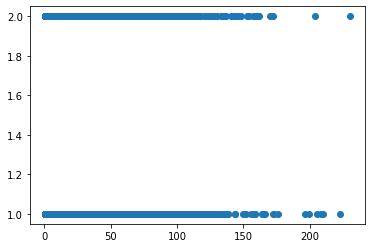

In [17]:
plt.figure(1)
plt.plot(df.total_restaurants,df["Neighborhood Tiers"],'o')


We do not see an obvious trend between the total number of restaurants and neighborhood tiers. 

#### Total Reviews vs Neighborhood Tiers

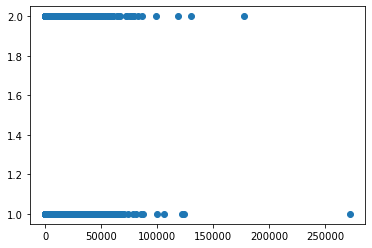

In [18]:
plt.plot(df["total_reviews"], df["Neighborhood Tiers"],'o')
plt.show()

We do not see an obvious trend between the total reviews of restaurants and neighborhood tiers.

#### Coffee categories vs Neighborhood Tiers

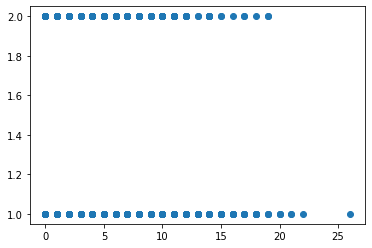

In [19]:
y = df[["coffee",	"coffeeroasteries", "cafes",	"brasseries",	"hkcafe"
        ,	"themedcafes",	"bistros"]].sum(axis=1)

plt.plot(y, df["Neighborhood Tiers"],'o')
plt.show()

We do see an slight trend in Tier1 neighborhoods having more cafes and coffee shops

#### Beer categories vs Neighborhood Tiers

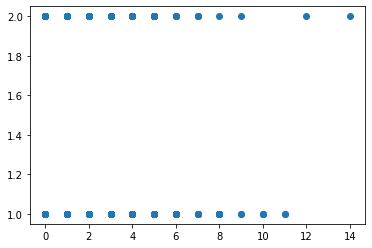

In [20]:
y = df[[ "beer_and_wine",	"beerbar",	"beergardens",	"breweries",	"brewpubs","champagne_bars",
        "distilleries",	"meaderies",	"wineries"]].sum(axis=1)

plt.plot(y, df["Neighborhood Tiers"],'o')
plt.show()

We see an slight trend in Tier2 neighborhoods having more bars and beer and wine establishments

#### African categories vs Neighborhood Tiers

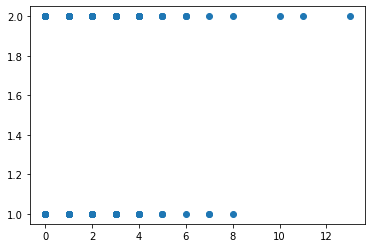

In [22]:
y = df[[ "african",	"egyptian",	"eritrean",	"ethiopian",	"iberian",	"moroccan",
           "senegalese","somali",	"southafrican"]].sum(axis=1)
plt.plot(y, df["Neighborhood Tiers"],'o')
plt.show()

There is an obvious trend in Tier2 neighborhoods having African cusine restaurants than Tier1

#### New and Traditional American categories vs Neighborhood Tiers

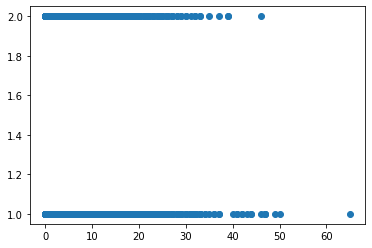

In [33]:
y = df[['newamerican','tradamerican']].sum(axis=1)
plt.plot(y, df["Neighborhood Tiers"],'o')
plt.show()

Tier1 neighborhoods have more New and Traditional American restaurants than Tier2 neighborhoods.

#### Mexican categories vs Neighborhood Tiers

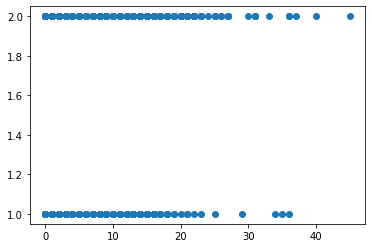

In [36]:
y = df[["mexican"]].sum(axis=1)
plt.plot(y, df["Neighborhood Tiers"],'o')
plt.show()

There is an obvious trend of neighborhood Tier2 having more Mexican establishments than Tier1 neighborhoods. 


The above trend analysis shows a slight trend for certain restaurant categories like Mexican and African cusines being in Tier2 a lot more and Tier1 neighborhoods having more cafes. 

# Tiers By State

In [38]:
df1 = df.groupby(["CountyName"]).count()["Neighborhood Tiers"]

In [39]:
df_state_tiers = df.loc[df['Neighborhood Tiers'].isin([1,2,3])].copy()

# List in descending order the number of neighborhood tiers in each state:
print('# Of Restaurants Per State:','\n',
      df_state_tiers['Neighborhood Tiers'].groupby(df_state_tiers['State']).count().sort_values(ascending=False))

# Of Restaurants Per State: 
 State
CA    978
TX    977
PA    864
NY    835
OH    765
IL    665
FL    637
MI    488
IN    444
MO    441
VA    387
NC    384
GA    380
IA    371
TN    360
MN    348
AL    325
WI    302
WA    268
KY    267
KS    263
MD    254
CO    241
AR    237
LA    236
OK    234
AZ    211
SC    207
WV    204
OR    192
NE    190
MS    137
UT    107
NJ     95
NV     87
MT     82
ID     77
NM     72
SD     63
CT     60
DE     50
VT     48
ND     41
WY     37
AK     27
DC     23
HI     22
NH      2
MA      2
RI      1
Name: Neighborhood Tiers, dtype: int64


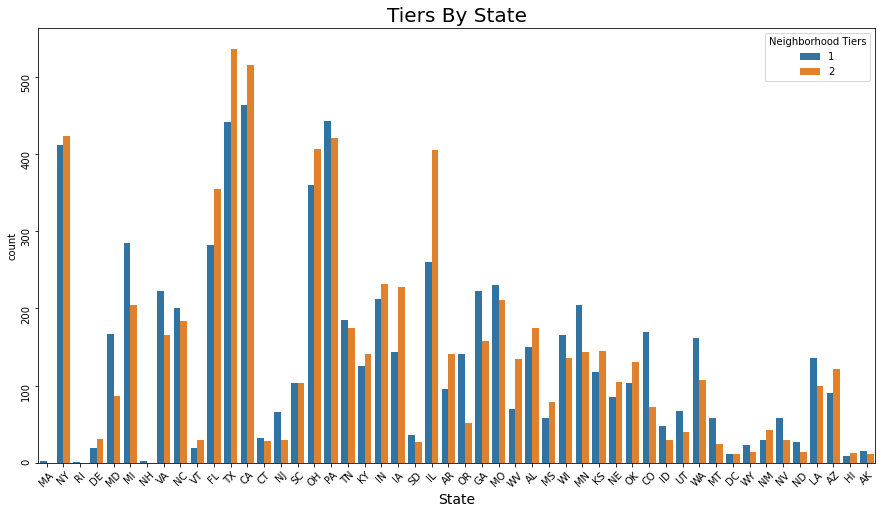

In [40]:
# Create a bar chart comparing the # of each neighborhood tier in each state:
plt.figure(figsize=(15,8))
sns.countplot(data=df_state_tiers, x='State',hue='Neighborhood Tiers')

# Add chart title and labels
plt.title('Tiers By State', fontsize=20)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=45);
plt.yticks(rotation=90);

# Neighborhood Tiers by # of Reviews and Yelp Rating

In [41]:
#read in the expanded_restaurants.csv
df_tiers = pd.read_csv("yelp_housing_merge.csv")
df_tiers_extract = df_tiers[["postal_code", "rating", "review_count"]]
df_tiers.shape


(240589, 19)

In [42]:
#extract postal code and neighborhood tiers 
df_tier = df[["postal_code", "Neighborhood Tiers"]]
#merge df_tier and df_tiers
#merge dataframes
frames = [df_tier, df_tiers_extract]
star_vs_review_df = reduce(lambda left,right: pd.merge(left,right,on='postal_code'), frames)
star_vs_review_df = star_vs_review_df.drop(columns="postal_code", axis=1)
print(star_vs_review_df.shape)
star_vs_review_df.head()

(240589, 3)


,Neighborhood Tiers,rating,review_count
0,1,4.0,156
1,1,4.5,140
2,1,4.0,112
3,1,4.0,21
4,1,4.5,97


In [43]:
star_vs_review_df.to_csv("stars_vs_review.csv")

In [44]:
# Print total number of reviews for each inspection grade:
print('# of Restaurants Per Yelp Rating:','\n',
      star_vs_review_df['review_count'].groupby(df_tiers['rating']).count())


# of Restaurants Per Yelp Rating: 
 rating
0.0       64
1.0     4322
1.5     4909
2.0     9094
2.5    13275
3.0    21921
3.5    42763
4.0    71966
4.5    52312
5.0    19963
Name: review_count, dtype: int64


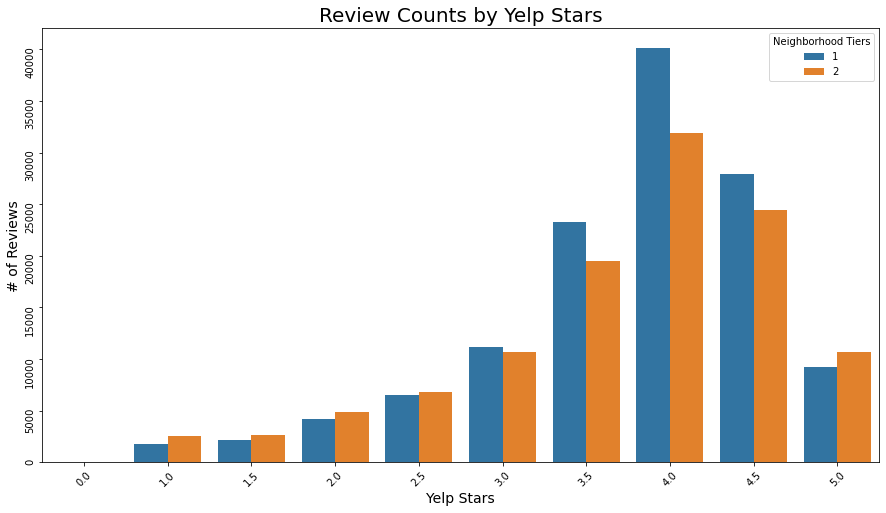

In [45]:
# Create a bar chart comparing the # of reviews :
plt.figure(figsize=(15,8))
sns.countplot(data=star_vs_review_df, x='rating', hue='Neighborhood Tiers')

# Add chart title and labels
plt.title('Review Counts by Yelp Stars', fontsize=20)
plt.xlabel('Yelp Stars', fontsize=14)
plt.ylabel('# of Reviews', fontsize=14);
plt.xticks(rotation=45);
plt.yticks(rotation=90);

Tier1 has more reviews than Tier2 and for both categories having a similar distribution centered around 3.5-4.5 Yelp stars. 

# Corelation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.

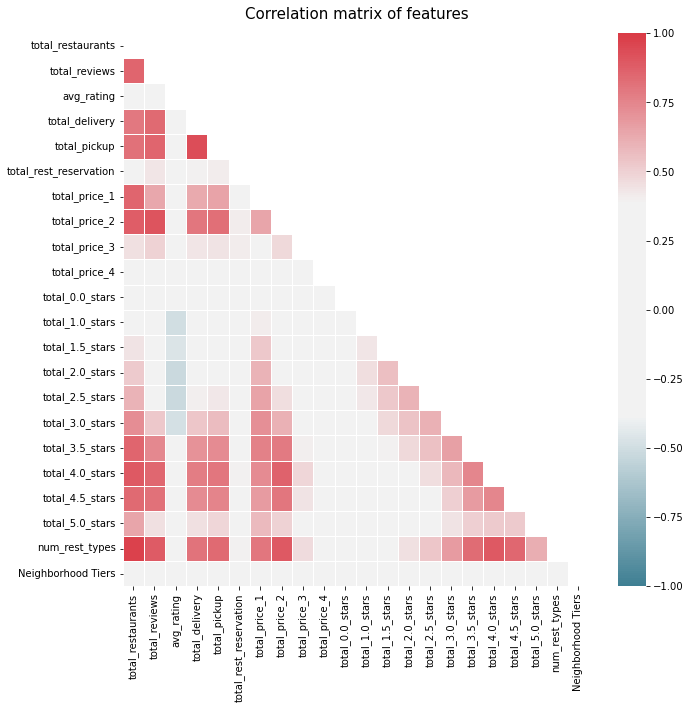

In [48]:
df1 = df[['total_restaurants','total_reviews','avg_rating','total_delivery','total_pickup','total_rest_reservation',
        'total_price_1','total_price_2','total_price_3','total_price_4','total_0.0_stars','total_1.0_stars',
        'total_1.5_stars','total_2.0_stars','total_2.5_stars','total_3.0_stars','total_3.5_stars','total_4.0_stars',
        'total_4.5_stars','total_5.0_stars','num_rest_types', 'Neighborhood Tiers']]

corr = df1.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

fig.suptitle('Correlation matrix of features', fontsize=15)

fig.tight_layout()
#code adapted from https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python